In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_curve, auc

raw_data = pd.read_csv('../00-dataset/00-raw-data/dataset.csv')

raw_data

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.730000,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.420000,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.950000,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.640000,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,75.0,23.060250,0,Caucasian,M,177.8,Floor,...,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,NaN,0
91709,66119,13486,121,56.0,47.179671,0,Caucasian,F,183.0,Floor,...,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
91710,8981,58179,195,48.0,27.236914,0,Caucasian,M,170.2,Accident & Emergency,...,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
91711,33776,120598,66,NaN,23.297481,0,Caucasian,F,154.9,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0


## Preprocessing

In [18]:
# One-Hot Encoding
data = pd.get_dummies(raw_data)

# Handle missing values
data = data.fillna(data.median())

data

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,66154,25312,118,68.0,22.730000,0,180.3,92,0.541667,73.9,...,True,False,False,False,False,False,False,False,False,False
1,114252,59342,81,77.0,27.420000,0,160.0,90,0.927778,70.2,...,False,False,False,False,False,False,True,False,False,False
2,119783,50777,118,25.0,31.950000,0,172.7,93,0.000694,95.3,...,False,False,False,True,False,False,False,False,False,False
3,79267,46918,118,81.0,22.640000,1,165.1,92,0.000694,61.7,...,True,False,False,False,False,False,False,False,False,False
4,92056,34377,33,19.0,27.654655,0,188.0,91,0.073611,80.3,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,75.0,23.060250,0,177.8,927,0.298611,72.9,...,True,False,False,False,False,False,False,False,False,False
91709,66119,13486,121,56.0,47.179671,0,183.0,925,0.120139,158.0,...,True,False,False,False,False,False,False,False,False,False
91710,8981,58179,195,48.0,27.236914,0,170.2,908,0.046528,78.9,...,False,False,False,True,False,False,False,False,False,False
91711,33776,120598,66,65.0,23.297481,0,154.9,922,0.081944,55.9,...,False,False,False,False,False,False,True,False,False,False


In [19]:
data.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
count,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,...,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,91713.000000,0.0,91713.000000
mean,65606.079280,65537.131464,105.669262,62.433548,29.128570,0.183736,169.648256,508.357692,0.835766,83.917765,...,0.000850,0.015570,0.223436,0.012888,0.025961,0.007011,0.004100,0.020477,NaN,0.086302
std,37795.088538,37811.252183,62.854406,16.393595,8.124165,0.387271,10.716719,228.989661,2.487756,24.645926,...,0.029151,0.123806,0.416551,0.112792,0.159021,0.083438,0.063898,0.141626,NaN,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,32852.000000,32830.000000,47.000000,53.000000,23.787760,0.000000,162.560000,369.000000,0.035417,67.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,65665.000000,65413.000000,109.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,80.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
75%,98342.000000,98298.000000,161.000000,75.000000,32.653061,0.000000,177.800000,679.000000,0.409028,96.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,186.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


## Model

In [20]:
X = data.drop(columns=['hospital_death'])
y = data['hospital_death']

In [21]:
np.random.seed(42)
indices = np.random.permutation(len(X))

# 60% train, 20% validation, 20% test
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train = X.iloc[indices[:train_size]]
y_train = y.iloc[indices[:train_size]]
X_val = X.iloc[indices[train_size:train_size+val_size]]
y_val = y.iloc[indices[train_size:train_size+val_size]]
X_test = X.iloc[indices[train_size+val_size:]]
y_test = y.iloc[indices[train_size+val_size:]]

Validation Set Performance:
Accuracy: 0.9275
F1 Score: 0.3562
Log Loss: 0.2272

Test Set Performance:
Accuracy: 0.9259
F1 Score: 0.3734
Log Loss: 0.2297

AUC (Validation Set): 0.8712350916274764


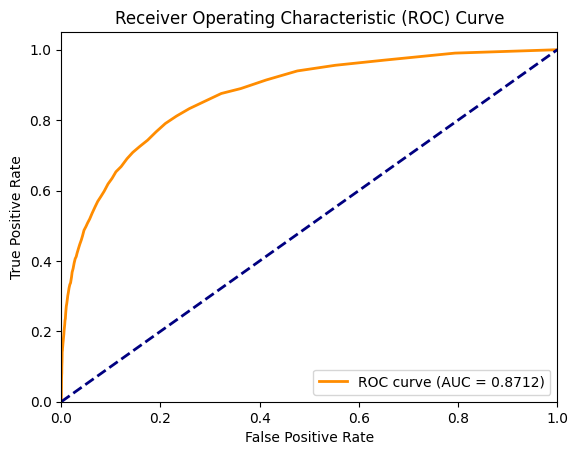

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluate performance on validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val, model.predict_proba(X_val))

# Evaluate performance on test set
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
log_loss_test = log_loss(y_test, model.predict_proba(X_test))

print("Validation Set Performance:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print(f"Log Loss: {log_loss_val:.4f}")

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Log Loss: {log_loss_test:.4f}")

# ROC and AUC evaluation
fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

print("\nAUC (Validation Set):", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()